This code was adapted from Chris Holden (ceholden@gmail.com) Chaoter 5 Lesson on Ladncover Classification: https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html - https://github.com/ceholden



### Imports

In [1]:
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Sklearn Libraries
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, \
            classification_report, recall_score, precision_recall_curve
from sklearn.metrics import accuracy_score
from pprint import pprint


### Preparing The Dataset

In [2]:
# Read in our satellite and label image
satellite_img = gdal.Open('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/classification_training_data/final_filled_l8_training_data.tif', gdal.GA_ReadOnly)
training_img = gdal.Open('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/classification_training_data/third_remerge_landcover_training_data.tif', gdal.GA_ReadOnly)


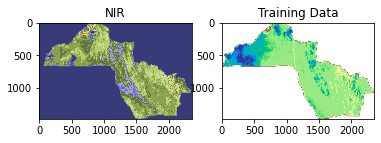

In [3]:

img = np.zeros((satellite_img.RasterYSize, satellite_img.RasterXSize, satellite_img.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(satellite_img.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = satellite_img.GetRasterBand(b + 1).ReadAsArray()
    
lbls = training_img.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 6], cmap=plt.cm.tab20b)
plt.title('NIR')

plt.subplot(122)
plt.imshow(lbls, cmap=plt.cm.terrain)
plt.title('Training Data')

plt.show()

In [4]:
lbls.shape

(1483, 2353)

In [5]:
img.shape

(1483, 2353, 7)

In [6]:
unique, counts = np.unique(lbls, return_counts=True)
list(zip(unique, counts))

[(1, 120176), (2, 179811), (3, 984873), (4, 4036), (5, 33701), (6, 2166902)]

Creating the X feature matrix array and the y labels matrix to be fed into the Random Forest

In [7]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (lbls >0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(lbls[lbls >0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

#this is a quick numpy trick for flattening
X = img[lbls >0 ]  # include 8th band, which is Fmask, for now
y = lbls[lbls >0]


print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))



We have 3489499 samples
The training data include 6 classes: [1 2 3 4 5 6]
Our X matrix is sized: (3489499, 7)
Our y array is sized: (3489499,)


In [8]:
unique, counts = np.unique(y, return_counts=True)
list(zip(unique, counts))

[(1, 120176), (2, 179811), (3, 984873), (4, 4036), (5, 33701), (6, 2166902)]

## Stratifying Data

k-fold

In [ ]:
#stratified k-cross validation to balance the classes
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)

In [ ]:
StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

shuffle split

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

StratifiedShuffleSplit(n_splits=10, random_state=0)
        
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 447440 1214577  148771 ... 1438313 3450855  610532] TEST: [ 218227 1021803 1720061 ...  571318 2212705  944726]
TRAIN: [1844567 3318783  133266 ... 1160308  604283  257108] TEST: [3112883  291382 2234079 ... 2451648 2227137  558480]
TRAIN: [2833297 1800309 2289446 ... 3476799 1372770 1068551] TEST: [   5210  445813   78789 ...  356665 1527598 1458178]
TRAIN: [2112062  321744  394542 ... 2226515 1469961 3448677] TEST: [ 121151 3157159  899609 ... 3139593  141194 1115405]
TRAIN: [1310934 1988140 2221969 ... 1619645 3015735 2767622] TEST: [2662952  396183 1754490 ... 3178325 2235687 2829341]
TRAIN: [1655985 1806009 1648654 ... 2242066 3068628  674886] TEST: [ 396715 1629476  329702 ... 1624121 1695005 1641314]
TRAIN: [ 324576 2070371 1688834 ... 3172554  551696  214000] TEST: [2112725 2851132  807712 ...  165736  973214 2692882]
TRAIN: [ 148528 2439761 2278734 ... 1424489 1920455 1507841] TEST: [ 563818  117180 1068845 ...  190611 2207267 3294974]
TRAIN: [ 628367 2865721  979480 

In [10]:
urban = np.count_nonzero(y_test ==1)
urban

36053

### Training The Random Forest

In [11]:
# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)


In [12]:

# Fit our model to training data
train = rf.fit(X_train, y_train)

### Training Performance

In [13]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))


Our OOB prediction of accuracy is: 92.75294976887797%


In [14]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y_train
df['predict'] = rf.predict(X_train)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict      1       2       3     4      5        6      All
truth                                                        
1        76113       0       0     0      0     8010    84123
2            0  114387       0     0      0    11481   125868
3            0       0  679445     0      0     9966   689411
4            0       0       0  2747      0       78     2825
5            0       0       0     0  21936     1655    23591
6            0       0       0     0      0  1516831  1516831
All      76113  114387  679445  2747  21936  1548021  2442649


### Validation Performance

In [15]:
val = rf.predict(X_test)

In [19]:
target_names = ['Cropland', 'Shrubland', 'Forest', 'Urban', 'Water','Clouds']

In [20]:
print(classification_report(y_test, val, target_names=target_names))

ValueError: Number of classes, 6, does not match size of target_names, 5. Try specifying the labels parameter

Confusion matrix:
[[ 16080   5431  11057     40     70   3375]
 [  5402  22220  21259     42    104   4916]
 [  3132   8434 279010     56    596   4234]
 [   205    106    268    577     19     36]
 [   174    428   5551     30   3210    717]
 [     0      0      0      0      0 650071]]


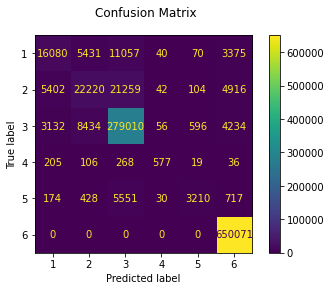

In [18]:
disp = metrics.plot_confusion_matrix(rf, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

### Band Importance

In [19]:
bands = [1, 2, 3, 4, 5, 6,7,8,9,10]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.03523731795533902
Band 2 importance: 0.16187343598614634
Band 3 importance: 0.16856448767527013
Band 4 importance: 0.1529682753739492
Band 5 importance: 0.1580951850873987
Band 6 importance: 0.17101924620247358
Band 7 importance: 0.15224205171942307


#### Scientific comment on band importance
The SWIR bands seem to be the most important features. The SWIR range of the EM spectrum allows the user to see certain absorption features very clearly due to certain materials only displaying absorption features in that range, which allows you to determine vegetation health as well as delineate between soil and decaying canopy.

In [ ]:
#current parameters in use

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())


## Applying to Study Region 

In [135]:
# Read in our satellite and label image
new_img_path = gdal.Open('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/Counterfactual_Test_Data/Filled/Counterfactual_2020_Filled.tif', gdal.GA_ReadOnly)


In [136]:
new_img = np.zeros((new_img_path.RasterYSize, new_img_path.RasterXSize, new_img_path.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(new_img_path.GetRasterBand(1).DataType))
for b in range(new_img.shape[2]):
    new_img[:, :, b] = new_img_path.GetRasterBand(b + 1).ReadAsArray()

In [137]:
new_shape = (new_img.shape[0] * new_img.shape[1], new_img.shape[2])
new_shape

img_as_array = new_img[:, :, :7].reshape(new_shape)

print('Reshaped from {o} to {n}'.format(o=new_img.shape,
                                        n=img_as_array.shape))


Reshaped from (547, 1105, 7) to (604435, 7)


In [138]:
class_prediction = rf.predict(img_as_array)

In [139]:
# Reshape our classification map
class_prediction_reshaped = class_prediction.reshape(new_img[:, :, 0].shape)

In [140]:
class_prediction_reshaped.max()

6

In [141]:
#save as numpy array ahead of analysis
np.save('/gws/nopw/j04/ai4er/users/jl2182/data/Figures/Counterfactual_Classified_Landcover/Counterfactual_2020_Classified.npy',class_prediction_reshaped)

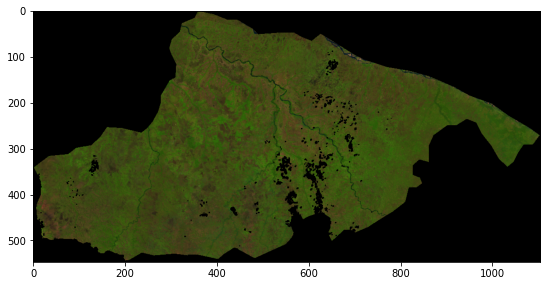

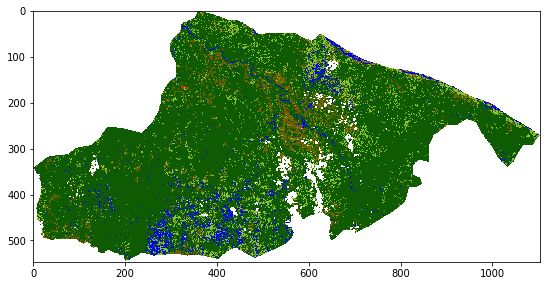

In [142]:
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
    
img543 = color_stretch(new_img, [5, 4, 3], (0, 7000))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (1, (111, 97, 6,255)),  # Cropland (brown)
    (2, (135, 198, 42,255)),  # Shrubland (light green)
    (3, (15, 91, 3,255)),  # Forest (dark green)
    (4, (255, 26, 0,255)),  # Urban (red)
    (5, (0, 0, 255,255)),  # Water (blue)
    (6, (0, 0, 0,0)) #No Data/Clouds
))
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the classmap next to the image
plt.figure(figsize = (20,25))
plt.subplot(121)
plt.imshow(img543)

plt.figure(figsize = (20,25))
plt.subplot(122)
#plt.legend(handles=cmap, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.imshow(class_prediction_reshaped, cmap=cmap, interpolation='none')

plt.savefig( '/gws/nopw/j04/ai4er/users/jl2182/data/Figures/Counterfactual_Classified_Landcover/Counterfactual_2020_Classified.tif')
plt.savefig( '/gws/nopw/j04/ai4er/users/jl2182/data/Figures/Counterfactual_Classified_Landcover/Counterfactual_2020_Classified.png')
#plt.show()

In [ ]:
#img = np.ma.masked_values(img_as_array, 0)

In [ ]:
#class_pred = np.ones(img_as_array.shape)
#for i in range(img_as_array.shape[0]):
    #for j in range(img_as_array.shape[1]):
        #if img_as_array[i,j] == 0.:
            #class_pred = 0
        #if img_as_array[i,j] != 0:
            #class_pred = rf.predict(img_as_array)

In [ ]:
#cp = np.where(img_as_array ==0,0,rf.predict(img_as_array).reshape(new_img[:, :, 0].shape))